# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Download and import required packages

In [1]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [2]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [3]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [4]:
seed = 91322
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [5]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
# urls = (
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
#     "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
# )
# file_names = (
#     'ted2020.tgz', # train & dev
#     'test.tgz', # test
# )
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
# for u, f in zip(urls, file_names):
#     path = prefix/f
#     if not path.exists():
#         !wget {u} -O {path}
#     if path.suffix == ".tgz":
#         !tar -xvf {path} -C {prefix}
#     elif path.suffix == ".zip":
#         !unzip -o {path} -d {prefix}
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
# !rm -rf {prefix/'test'}

## Language

In [6]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [7]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [8]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [9]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [10]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [11]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [12]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [13]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [14]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [15]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [16]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [17]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [18]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [19]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-06 15:55:58 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-06 15:55:58 | INFO | fairseq.utils | rank   0: capabilities =  6.1  ; total memory = 10.915 GB ; name = NVIDIA GeForce GTX 1080 Ti              
2022-04-06 15:55:58 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [20]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-06 15:55:58 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2022-04-06 15:55:58 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [21]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-06 15:55:58 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-06 15:55:58 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-04-06 15:55:58 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-04-06 15:55:58 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2022-04-06 15:55:58 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-04-06 15:55:58 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-04-06 15:55:58 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [22]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  35,    4,   19, 1234,   12,   80,  374, 2905,  688,    7,    2]),
 'target': tensor([1956,    4,   40, 1201,  192,  162,  277, 1674,  859,   10,    2])}
'Source: so , i wanted to do something special today .'
'Target: 那麼 , 我今天想做點特別的事 。'


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [23]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-06 15:55:58 | WARNING | fairseq.tasks.fairseq_task | 2,510 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[180, 1281, 3715, 836, 788, 1923, 3680, 3630, 787, 1634]


{'id': tensor([549]),
 'nsentences': 1,
 'ntokens': 11,
 'net_input': {'src_tokens': tensor([[  1,   1,   1, 260,  24,  48, 593,  16, 345, 133, 185,  54, 971, 936,
             7,   2]]),
  'src_lengths': tensor([13]),
  'prev_output_tokens': tensor([[   2, 1207,  494, 2628, 1078,  102, 1598,  150,  637, 4259,  478,    1,
              1,    1,    1,    1]])},
 'target': tensor([[1207,  494, 2628, 1078,  102, 1598,  150,  637, 4259,  478,    2,    1,
             1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [24]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [25]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [26]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [27]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [28]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=8,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=16
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=16
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [29]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [30]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-06 15:56:00 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [31]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [32]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    lr = d_model ** (-0.5) * min(step_num ** (-0.5), step_num * (warmup_step ** (-1.5)))
    return lr

In [33]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

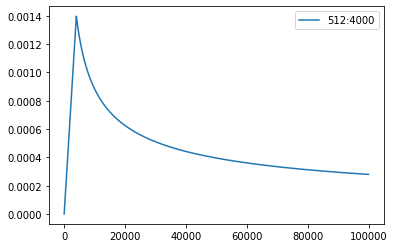

In [34]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [35]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast
total_gnorm = []

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        total_gnorm.append(gnorm.item())


        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [36]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [37]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [38]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [39]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [40]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-06 15:56:03 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-06 15:56:03 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-06 15:56:03 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-06 15:56:03 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-06 15:56:03 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-06 15:56:03 | INFO | hw5.seq2seq | num. model params: 52,324,352 (num. trained: 52,324,352)
2022-04-06 15:56:03 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [41]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-06 15:56:03 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326683]
2022-04-06 15:56:03 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/checkpoint_last.pt: step=2337 loss=3.9522705078125 bleu=16.88645790742033


2022-04-06 16:10:40 | INFO | hw5.seq2seq | training loss: 3.8147
2022-04-06 16:10:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s, valid_loss=3.21]/home/haoyu/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/haoyu/.local/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode

2022-04-06 16:11:15 | INFO | hw5.seq2seq | example source: and it's not the economy . richer country has a little higher .
2022-04-06 16:11:15 | INFO | hw5.seq2seq | example hypothesis: 這不是經濟學 。 富有的國家有更高的
2022-04-06 16:11:15 | INFO | hw5.seq2seq | example reference: 這不是經濟 , 較富裕的國家比較高
2022-04-06 16:11:15 | INFO | hw5.seq2seq | validation loss:	3.7757
2022-04-06 16:11:15 | INFO | hw5.seq2seq | BLEU = 19.38 50.7/26.1/14.3/8.2 (BP = 0.976 ratio = 0.976 hyp_len = 108131 ref_len = 110786)
2022-04-06 16:11:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint1.pt
2022-04-06 16:11:17 | INFO | hw5.seq2seq | end of epoch 1


2022-04-06 16:25:57 | INFO | hw5.seq2seq | training loss: 3.6561
2022-04-06 16:25:57 | INFO | hw5.seq2seq | begin validation


2022-04-06 16:26:28 | INFO | hw5.seq2seq | example source: we're going to focus on questions where you can't learn the answers because they're unknown .
2022-04-06 16:26:28 | INFO | hw5.seq2seq | example hypothesis: 我們會專注在問題上 , 你不能學習答案 , 因為他們是未知的 。
2022-04-06 16:26:28 | INFO | hw5.seq2seq | example reference: 我們將關注於你無法學到答案的問題上因為答案還沒有人知道的
2022-04-06 16:26:28 | INFO | hw5.seq2seq | validation loss:	3.6293
2022-04-06 16:26:28 | INFO | hw5.seq2seq | BLEU = 20.70 55.0/29.0/16.3/9.5 (BP = 0.929 ratio = 0.931 hyp_len = 103174 ref_len = 110786)
2022-04-06 16:26:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint2.pt
2022-04-06 16:26:30 | INFO | hw5.seq2seq | end of epoch 2


2022-04-06 16:41:10 | INFO | hw5.seq2seq | training loss: 3.5048
2022-04-06 16:41:10 | INFO | hw5.seq2seq | begin validation


2022-04-06 16:41:43 | INFO | hw5.seq2seq | example source: it is a very thin shell of atmosphere surrounding the planet .
2022-04-06 16:41:43 | INFO | hw5.seq2seq | example hypothesis: 這是非常薄的大氣層包圍著地球 。
2022-04-06 16:41:43 | INFO | hw5.seq2seq | example reference: 天空是一層非常薄的大氣層環繞著地球 。
2022-04-06 16:41:43 | INFO | hw5.seq2seq | validation loss:	3.4903
2022-04-06 16:41:43 | INFO | hw5.seq2seq | BLEU = 22.02 56.0/30.4/17.3/10.3 (BP = 0.937 ratio = 0.939 hyp_len = 104022 ref_len = 110786)
2022-04-06 16:41:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint3.pt
2022-04-06 16:41:44 | INFO | hw5.seq2seq | end of epoch 3


2022-04-06 16:56:20 | INFO | hw5.seq2seq | training loss: 3.3431
2022-04-06 16:56:20 | INFO | hw5.seq2seq | begin validation


2022-04-06 16:56:51 | INFO | hw5.seq2seq | example source: i've designed too many faces in the past that were intended to mitigate technical problems .
2022-04-06 16:56:51 | INFO | hw5.seq2seq | example hypothesis: 過去我設計過太多臉孔 , 本來要減輕技術問題 。
2022-04-06 16:56:51 | INFO | hw5.seq2seq | example reference: 我過去設計了很多字體都為了緩解技術問題
2022-04-06 16:56:51 | INFO | hw5.seq2seq | validation loss:	3.3839
2022-04-06 16:56:51 | INFO | hw5.seq2seq | BLEU = 23.22 58.5/32.4/18.8/11.4 (BP = 0.921 ratio = 0.924 hyp_len = 102362 ref_len = 110786)
2022-04-06 16:56:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint4.pt
2022-04-06 16:56:52 | INFO | hw5.seq2seq | end of epoch 4


2022-04-06 17:11:24 | INFO | hw5.seq2seq | training loss: 3.2151
2022-04-06 17:11:24 | INFO | hw5.seq2seq | begin validation


2022-04-06 17:11:57 | INFO | hw5.seq2seq | example source: so let's go one more floor down .
2022-04-06 17:11:57 | INFO | hw5.seq2seq | example hypothesis: 讓我們再往下走 。
2022-04-06 17:11:57 | INFO | hw5.seq2seq | example reference: 我們再往下一層走 ,
2022-04-06 17:11:57 | INFO | hw5.seq2seq | validation loss:	3.3492
2022-04-06 17:11:57 | INFO | hw5.seq2seq | BLEU = 23.66 58.4/32.7/19.2/11.8 (BP = 0.923 ratio = 0.926 hyp_len = 102562 ref_len = 110786)
2022-04-06 17:11:57 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint5.pt
2022-04-06 17:11:58 | INFO | hw5.seq2seq | end of epoch 5


2022-04-06 17:26:32 | INFO | hw5.seq2seq | training loss: 3.1176
2022-04-06 17:26:32 | INFO | hw5.seq2seq | begin validation


2022-04-06 17:27:05 | INFO | hw5.seq2seq | example source: or maybe it's because when i was a teenager back in the '50s , my uncle henry having denounced the ku klux klan and been bombed for his trouble and had crosses burned in his yard , living under death threat took his wife and children to massachusetts for safety and went back to south carolina to face down the klan alone .
2022-04-06 17:27:05 | INFO | hw5.seq2seq | example hypothesis: 或許是因為我在五零年代時 , 一位青少年時期 , 我叔父亨利宣佈了kukluxklan , 被他麻煩轟炸了 , 他的麻煩在他的院子裡 , 他的妻子和兒童在麻薩諸塞州的死亡威脅 , 帶著安全的卡羅來到南卡羅萊納州 。
2022-04-06 17:27:05 | INFO | hw5.seq2seq | example reference: 或又在那五十年代 , 當我還是十幾來歲時 , 我的叔叔亨利 , 曾被3k黨譴折過和受到攻擊及在他的後院燃燒十字架 , 在生活中充滿死亡的威脅 , 為了安全的考量帶著他的妻子和小孩到麻州之後一個人回到南卡羅納州對抗3k黨 。
2022-04-06 17:27:05 | INFO | hw5.seq2seq | validation loss:	3.2914
2022-04-06 17:27:05 | INFO | hw5.seq2seq | BLEU = 24.44 58.0/32.5/19.1/11.8 (BP = 0.958 ratio = 0.959 hyp_len = 106223 ref_len = 110786)
2022-04-06 17:27:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /

2022-04-06 17:41:45 | INFO | hw5.seq2seq | training loss: 3.0342
2022-04-06 17:41:45 | INFO | hw5.seq2seq | begin validation


2022-04-06 17:42:17 | INFO | hw5.seq2seq | example source: but we just have to leave that little bit of openness , to know .
2022-04-06 17:42:17 | INFO | hw5.seq2seq | example hypothesis: 但我們只需要留下一點點開放 , 才能知道 。
2022-04-06 17:42:17 | INFO | hw5.seq2seq | example reference: 但是 , 其實我們只需要放寬心胸去了解.
2022-04-06 17:42:17 | INFO | hw5.seq2seq | validation loss:	3.2730
2022-04-06 17:42:17 | INFO | hw5.seq2seq | BLEU = 24.77 57.7/32.4/19.2/11.9 (BP = 0.970 ratio = 0.970 hyp_len = 107470 ref_len = 110786)
2022-04-06 17:42:18 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint7.pt
2022-04-06 17:42:19 | INFO | hw5.seq2seq | end of epoch 7


2022-04-06 17:56:54 | INFO | hw5.seq2seq | training loss: 2.9642
2022-04-06 17:56:54 | INFO | hw5.seq2seq | begin validation


2022-04-06 17:57:24 | INFO | hw5.seq2seq | example source: and a significant minority of those 500 million people like to spend some of their leisure time and spare cash sleeping with prostitutes , sticking 50 euro notes up their nose and employing illegal migrant laborers .
2022-04-06 17:57:24 | INFO | hw5.seq2seq | example hypothesis: 而這五億人口中有很大一部分人喜歡花一些休閒的時間和空閒時間睡在妓女身上 , 把五十歐元的筆記記記記記記記記記記記記記記記記記記記記記記記記記記記記記記下來 , 僱用非法移民 。
2022-04-06 17:57:24 | INFO | hw5.seq2seq | example reference: 關鍵的少數這五億人口喜歡渡假、花錢找妓女把五十歐元捲起塞在鼻孔裏雇用非法的勞工
2022-04-06 17:57:24 | INFO | hw5.seq2seq | validation loss:	3.2586
2022-04-06 17:57:24 | INFO | hw5.seq2seq | BLEU = 24.37 60.3/34.3/20.4/12.7 (BP = 0.900 ratio = 0.905 hyp_len = 100240 ref_len = 110786)
2022-04-06 17:57:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint8.pt
2022-04-06 17:57:25 | INFO | hw5.seq2seq | end of epoch 8


2022-04-06 18:11:59 | INFO | hw5.seq2seq | training loss: 2.9049
2022-04-06 18:11:59 | INFO | hw5.seq2seq | begin validation


2022-04-06 18:12:30 | INFO | hw5.seq2seq | example source: on your righthand side , you can see a cucumber leaf , in the middle , a cotton leaf , and on the left , a tomato leaf with these little stipplings .
2022-04-06 18:12:30 | INFO | hw5.seq2seq | example hypothesis: 在你的右手邊 , 你可以看到一片黃瓜葉 , 在中間 , 一片棉葉 , 在左邊 , 一片番茄葉 , 上面有這些小插頭 。
2022-04-06 18:12:30 | INFO | hw5.seq2seq | example reference: 右手邊你可以看見黃瓜的葉子 , 中間是棉花的葉子 , 左邊是蕃茄的葉子 ,
2022-04-06 18:12:30 | INFO | hw5.seq2seq | validation loss:	3.2408
2022-04-06 18:12:30 | INFO | hw5.seq2seq | BLEU = 25.16 58.7/33.3/19.7/12.2 (BP = 0.960 ratio = 0.961 hyp_len = 106467 ref_len = 110786)
2022-04-06 18:12:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/haoyu/Desktop/2022ML/hw5/checkpoints/rnn/checkpoint9.pt
2022-04-06 18:12:32 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:  14%|█▍        | 111/791 [02:02<11:54,  1.05s/it, loss=2.91]

# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
Traceback (most recent call last):
  File "./fairseq/scripts/average_checkpoints.py", line 158, in <module>
    main()
  File "./fairseq/scripts/average_checkpoints.py", line 143, in main
    args.inputs = last_n_checkpoints(
  File "./fairseq/scripts/average_checkpoints.py", line 93, in last_n_checkpoints
    raise Exception(
Exception: ('Found {} checkpoint files but need at least {}', 2, 5)


## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-06 15:42:28 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/avg_last_5_checkpoint.pt!
2022-04-06 15:42:28 | INFO | hw5.seq2seq | begin validation


2022-04-06 15:42:59 | INFO | hw5.seq2seq | example source: we're going to focus on questions where you can't learn the answers because they're unknown .
2022-04-06 15:42:59 | INFO | hw5.seq2seq | example hypothesis: 我們會把焦點放在你無法學會的問題上 , 因為他們是不熟悉的 。
2022-04-06 15:42:59 | INFO | hw5.seq2seq | example reference: 我們將關注於你無法學到答案的問題上因為答案還沒有人知道的
2022-04-06 15:42:59 | INFO | hw5.seq2seq | validation loss:	3.9523
2022-04-06 15:42:59 | INFO | hw5.seq2seq | BLEU = 16.89 48.0/23.8/12.6/7.0 (BP = 0.948 ratio = 0.950 hyp_len = 105200 ref_len = 110786)


## Generate Prediction

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)

2022-04-06 15:43:23 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2022-04-06 15:43:23 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2022-04-06 15:43:23 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction: 100%|██████████| 17/17 [00:25<00:00,  1.48s/it]


In [ ]:
pos_emb_2 = model.decoder.embed_positions.weights.cpu().detach()
pos_emb_2.size()

In [ ]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

dist_out_2 = 1-pairwise_distances(pos_emb_2, metric="cosine")
print(dist_out_2.shape[0])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dist_out_2.reshape((1026,1026)))
plt.colorbar()
plt.savefig('./problem_1-1.png')#儲存圖片

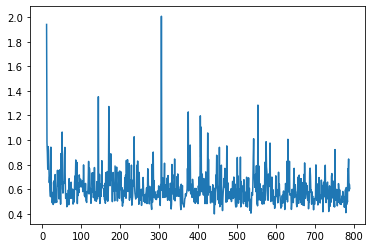

In [ ]:
# print(len(total_gnorm))
plt.plot(total_gnorm)
plt.savefig('./problem_2-1.png')#儲存圖片
plt.show()



# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [ ]:
def clean_mono_corpus(mono_prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}').exists() and Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}').exists():
        print(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}', 'w') as l1_out_f:
            with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0: # remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0: # remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)

In [ ]:
clean_mono_corpus(mono_prefix, 'zh','en')

/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh & en exists. skipping clean.


In [ ]:
!head {data_prefix + '.clean.' + 'zh'} -n 5
!head {data_prefix + '.clean.' + 'en'} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
for lang in ['zh','en']:
    out_path = mono_prefix/f'mono.tok.{lang}'
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
            with open(mono_prefix/f'ted_zh_corpus.deduped.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)

/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/mono/mono.tok.zh exists. skipping spm_encode.
/home/haoyu/Desktop/2022ML/hw5/DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.


### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization

if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
generate_prediction( model, task ,split="mono" ,outfile="./DATA/rawdata/mono/mono_prediction.txt" )

2022-04-05 21:10:09 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2022-04-05 21:10:09 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2022-04-05 21:10:09 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono en-zh 781713 examples


prediction:   0%|          | 0/1715 [00:00<?, ?it/s]

In [ ]:
!head {'./DATA/rawdata/mono/mono_prediction.txt'} -n 5

嗯...
嗯...
嗯...
嗯...
嗯...


### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
with open(mono_prefix/f'mono.tok.en', 'w') as out_f:
    with open('./DATA/rawdata/mono/mono_prediction.txt', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

In [ ]:
# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = Path('./DATA/rawdata/mono/mono.tok') # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
         --source-lang 'zh'\
         --target-lang 'en'\
         --trainpref {monopref}\
         --destdir {binpath}\
         --srcdict {src_dict_file}\
         --tgtdict {tgt_dict_file}\
         --workers 2

DATA/data-bin/synthetic exists, will not overwrite!


In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/transformer-big",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)


In [ ]:
## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-05 21:59:14 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2022-04-05 21:59:14 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-05 21:59:17 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-05 21:59:17 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2022-04-05 21:59:17 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2022-04-05 21:59:17 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-04-05 21:59:17 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-04-05 21:59:17 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-04-05 21:59:17 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2022-04-05 21:59:17 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2022-04-05 21:59:17 | I

In [ ]:

sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  35,    4,   19, 1234,   12,   80,  374, 2905,  688,    7,    2]),
 'target': tensor([1956,    4,   40, 1201,  192,  162,  277, 1674,  859,   10,    2])}
'Source: so , i wanted to do something special today .'
'Target: 那麼 , 我今天想做點特別的事 。'


In [ ]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-05 21:59:30 | WARNING | fairseq.tasks.fairseq_task | 2,510 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[180, 1281, 3715, 836, 788, 1923, 3680, 3630, 787, 1634]


{'id': tensor([549]),
 'nsentences': 1,
 'ntokens': 11,
 'net_input': {'src_tokens': tensor([[  1,   1,   1, 260,  24,  48, 593,  16, 345, 133, 185,  54, 971, 936,
             7,   2]]),
  'src_lengths': tensor([13]),
  'prev_output_tokens': tensor([[   2, 1207,  494, 2628, 1078,  102, 1598,  150,  637, 4259,  478,    1,
              1,    1,    1,    1]])},
 'target': tensor([[1207,  494, 2628, 1078,  102, 1598,  150,  637, 4259,  478,    2,    1,
             1,    1,    1,    1]])}

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=8,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=8,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=16
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=16
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-06 09:53:16 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=512, bia

In [ ]:
# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

In [ ]:
sequence_generator = task.build_generator([model], config)

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-06 09:53:32 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-06 09:53:32 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-06 09:53:32 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-06 09:53:32 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-06 09:53:32 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-06 09:53:32 | INFO | hw5.seq2seq | num. model params: 39,729,152 (num. trained: 39,729,152)
2022-04-06 09:53:32 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 2


In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

RuntimeError: Error(s) in loading state_dict for Seq2Seq:
	size mismatch for encoder.layers.0.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.layers.0.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layers.0.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for encoder.layers.1.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.layers.1.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layers.1.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for encoder.layers.2.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.layers.2.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layers.2.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for encoder.layers.3.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.layers.3.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layers.3.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for encoder.layers.4.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.layers.4.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layers.4.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for encoder.layers.5.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for encoder.layers.5.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for encoder.layers.5.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder.layers.0.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for decoder.layers.0.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.layers.0.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder.layers.1.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for decoder.layers.1.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.layers.1.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder.layers.2.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for decoder.layers.2.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.layers.2.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder.layers.3.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for decoder.layers.3.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.layers.3.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder.layers.4.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for decoder.layers.4.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.layers.4.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for decoder.layers.5.fc1.weight: copying a param with shape torch.Size([2048, 512]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for decoder.layers.5.fc1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for decoder.layers.5.fc2.weight: copying a param with shape torch.Size([512, 2048]) from checkpoint, the shape in current model is torch.Size([512, 1024]).

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer-big'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer-big/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer-big/checkpoint30.pt', './checkpoints/transformer-big/checkpoint29.pt', './checkpoints/transformer-big/checkpoint28.pt', './checkpoints/transformer-big/checkpoint27.pt', './checkpoints/transformer-big/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer-big/avg_last_5_checkpoint.pt


In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-04 08:18:10 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-big/avg_last_5_checkpoint.pt: step=unknown loss=2.9982056617736816 bleu=25.128381350100387
2022-04-04 08:18:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/40 [00:00<?, ?it/s]

2022-04-04 08:18:41 | INFO | hw5.seq2seq | example source: and i had an armored organization at that point .
2022-04-04 08:18:41 | INFO | hw5.seq2seq | example hypothesis: 當時我有一個盔甲組織 。
2022-04-04 08:18:41 | INFO | hw5.seq2seq | example reference: 當時我的團隊都是全副武裝 。
2022-04-04 08:18:41 | INFO | hw5.seq2seq | validation loss:	2.9735
2022-04-04 08:18:41 | INFO | hw5.seq2seq | BLEU = 25.73 57.0/32.7/20.2/13.2 (BP = 0.969 ratio = 0.969 hyp_len = 108355 ref_len = 111811)


In [ ]:
generate_prediction(model, task, outfile="./prediction_back.txt")

2022-04-04 10:55:12 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2022-04-04 10:55:12 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2022-04-04 10:55:12 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
pos_emb_2 = model.decoder.embed_positions.weights.cpu().detach()
pos_emb_2.size()

In [ ]:
dist_out_2 = 1-pairwise_distances(pos_emb_2, metric="cosine")
print(dist_out_2.shape[0])

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(dist_out_2.reshape((1026,1026)))
plt.colorbar()
plt.savefig('./problem_1-2.png')#儲存圖片

In [ ]:
# print(len(total_gnorm))
plt.plot(total_gnorm)
plt.savefig('./problem_2-2.png')#儲存圖片
plt.show()